<a href="https://colab.research.google.com/github/paganpasta/eqxvision/blob/tutorial%2Fadv/Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attack (FGSM)

We will be making our way through generating an adversarial example using the Fast-Gradient Sign Method (FGSM). 

Based on Torchvision [tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html), check it out for a more in-depth understanding of adversarial examples.


The flow of this tutorial will be as:

- Prepare input image
- Initialise a model
- Compute FGSM
- Visualize the results

---


### Installing Dependencies

In [ ]:
!pip install eqxvision optax --quiet

### Required Imports

In [ ]:
from io import BytesIO
from urllib.request import urlopen

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import requests
from PIL import Image

import eqxvision as eqv


%matplotlib inline

import optax
from torchvision import transforms

### Preparing Image & Transforms

In [ ]:
# Download
response = requests.get(
    "https://cdn.britannica.com/80/150980-050-84B9202C/Giant-panda-cub-branch.jpg"
)
img = Image.open(BytesIO(response.content))
img = img.convert("RGB")

# Transform
mean = (0.485, 0.456, 0.406)
std_dev = (0.229, 0.224, 0.225)
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std_dev),
    ]
)
img = jnp.asarray(transform(img).unsqueeze(0).numpy())


def inv_transform(x):
    means = jnp.asarray(mean).reshape(3, -1)
    std_devs = jnp.asarray(std_dev).reshape(3, -1)
    func = lambda x, m, s: s * x + m
    x = jax.vmap(func)(x, means, std_devs)
    return jnp.transpose(x, (1, 2, 0))

### Prediction to Class Names

In [ ]:
# Prediction to class name mapping
cls_map_link = (
    "https://github.com/Waikato/wekaDeeplearning4j/blob/master/src/"
    "main/resources/class-maps/IMAGENET.txt?raw=True"
)
data = urlopen(cls_map_link).read().decode("utf-8").split("\n")
cls_map = {}
for i, line in enumerate(data):
    cls_map[i] = line.strip().split(",")[0]

### Initialising Model

In [6]:
model = eqv.models.resnet50(pretrained=True)
model = eqx.tree_inference(model, True)
key = jrandom.split(jrandom.PRNGKey(0), 1)

### Loss Computation

Keep an eye out for the change in position of `x` and `model`. We aim to compute the gradient w.r.t the input `x` instead of the model parameters. 
Equinox by default computes the gradient w.r.t the `first argument`. Read more on this [here](https://docs.kidger.site/equinox/api/filtering/filtered-transformations/#equinox.filter_grad).

In [8]:
@eqx.filter_value_and_grad
def compute_loss(x, model, y, keys):
    logits = jax.vmap(model, axis_name=("batch"))(x, key=keys)
    one_hot_actual = jax.nn.one_hot(y, num_classes=1000)
    return optax.softmax_cross_entropy(logits, one_hot_actual).mean()

### FGSM Computation

For an image $x$ and model $f$, the adversarial example is:

$x_{adv} = x + ϵ \times sign(\nabla_x f(x))$

In [47]:
output = jax.vmap(model, axis_name="batch")(img, key=key)
pred_cls = jnp.argmax(output, axis=1).item()
print(f"Original Category: {cls_map[pred_cls]}")

loss, grads = compute_loss(img, model, pred_cls, key)
del_x = 0.1 * jnp.sign(grads)
adv_img = img + del_x

output = jax.vmap(model, axis_name="batch")(adv_img, key=key)
pred_adv = jnp.argmax(output, axis=1).item()
print(f"Adversarial Category: {cls_map[pred_adv]}")

Original Category: giant panda
Adversarial Category: indri


### Visualisation

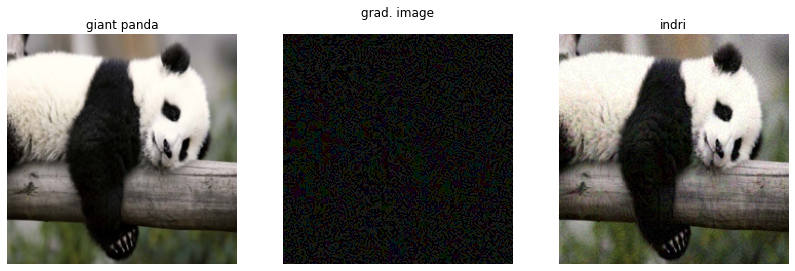

In [55]:
f, axs = plt.subplots(1, 3, figsize=(14, 14))
axs[0].imshow(inv_transform(img[0]))
axs[1].matshow(jnp.transpose(del_x[0], (1, 2, 0)))
axs[2].imshow(inv_transform(adv_img[0]))
axs[0].set_title(f"{cls_map[pred_cls]}")
axs[1].set_title("grad. image")
axs[2].set_title(f"{cls_map[pred_adv]}")
axs[0].axis("off")
axs[1].axis("off")
axs[2].axis("off")
plt.show()

*That's all Folks*